<a href="https://colab.research.google.com/github/TeachingTextMining/TextClassification/blob/main/03-SA-Transformers-Training-FineTuning/03-TextClassification-with-Transformers-FineTuning-Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificación de textos utilizando Transformers. Entrenando nuestro propio modelo


La clasificación de textos consiste en, dado un texto, asignarle una entre varias categorías. Algunos ejemplos de esta tarea son:

- dado un tweet, categorizar su connotación como positiva, negativa o neutra.
- dado un post de Facebook, clasificarlo como portador de un lenguaje ofensivo o no.  

En la figura se muestra una arquitectura típica de un sistema de aprendizaje automático para resolver esta tarea.

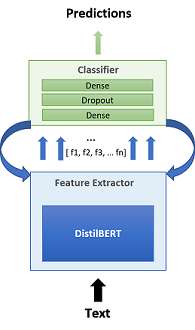

En la actividad exploraremos cómo utilizar la librería [Transformers](https://huggingface.co/transformers/) para construir este modelo y entrenarlo para clasificar reviews de [IMDB](https://www.imdb.com/) sobre películas en las categorías \[$positive$, $negative$\]. 

Puede encontrar más información sobre este problema en [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) y en [Large Movie Review Datase](http://ai.stanford.edu/~amaas/data/sentiment/). También consultar el tutorial sobre [Fine-tunning de modelos](https://huggingface.co/docs/transformers/training) en la web del proyecto  Transformers.

**Instrucciones:**

- siga las indicaciones y comentarios en cada apartado.


**Después de esta actividad nos habremos familiarizado con:**

- la arquitectura de un modelo para clasificar textos basado en Transformers.

- el re-entrenamiento de modelos para la clasificación de secuencias.

- aspectos importantes a tener en cuenta como el formato de los datos para entrenar y realizar nuevas predicciones.

**Requerimientos**
- python 3.6.12 - 3.8
- tensorflow==2.3.0
- transformers==4.2.1
- pandas==1.1.5
- plotly==4.13.0
- tqdm==4.56.0
- scikit-learn==0.24.0

**Note que:** en dependencia del entorno de ejecución, puede ser necesario instalar manualmente alguno de estos paquetes.



<a name="sec:setup"></a>
### Instalación de librerías e importación de dependencias.

Para comenzar, es preciso instalar las dependencias, realizar los imports necesarios y definir algunas funciones auxiliares.

Ejecute las siguientes casillas prestando atención a las instrucciones adicionales en los comentarios.

In [1]:
# instalar librerías. Esta casilla es últil por ejemplo si se ejecuta el cuaderno en Google Colab
# Note que existen otras dependencias como tensorflow, etc. que en este caso se encontrarían ya instaladas
#%%capture
#upgradeamos pipç

!pip install transformers==4.26.0 
!pip install tensorflow==2.9.0
!pip install pandas==1.3.5 
!pip install plotly==5.5.0 
!pip install scikit-learn==1.0.0

print('Done!')

Done!


In [8]:
# reset environment
#%reset -f

# para establecer caminos al guardar y leer archivos
import os
import tensorflow as tf

# para cargar datos y realizar pre-procesamiento básico
import pandas as pd
from collections import Counter
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight

# para evaluar los modelos 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

#  para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm

# para guardar el modelo
import pickle

import transformers
# algoritmos de clasificación, tokenizadores, etc.
# try:
#     from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig, TextClassificationPipeline
# except: 
#     pass 

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig
from transformers import TextClassificationPipeline

print('Done!')

Done!


In [9]:
# función auxiliar para obtener tensores de entrada al modelo a partir del texto
def get_model_inputs(cfg, data):
    # obtener ids y máscaras para el conjunto de entrenamiento
    # no es necesario convertir a tensores porque la salida del tokenizador se encuentra en este formato, 
    encodings = cfg['tokenizer'](data, truncation=True, padding='max_length', max_length=cfg['max_length'], return_tensors=cfg['framework'])

    # formatear los datos (tensores) de entrada de acuerdo con las opciones permitidas por TensorFlow
    # los nombres de las capas de Input creadas al construir el modelo ('input_ids', 'attention_mask', 'tfidf') 
    # son utilizados como llaves en los diccionarios que representan las entradas al modelo
    inputs = {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
            }
    return inputs

# función auxiliar para realizar predicciones con el modelo
def predict_model(model, cfg, data, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  inputs = get_model_inputs(cfg, data)
  scores = model.predict(inputs)['logits']  # la salida de este modelo es TFSequenceClassifierOutput, debe tomarse el valor asociado a la llave 'logits'
  
  # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
  if cfg['num_labels']==1: # si es clasificación binaria, este modelo devuelve solo 1 score por instancia
    res = {f'scores_{pref}': scores[:,0]}
  else:
    res = {f'scores_{pref}_{cls}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  labels = cfg['label_binarizer'].inverse_transform(scores)
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabéticamente
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))
  return res


# función auxiliar que evalúa los resultados de una clasificación
def evaluate_model(y_true, y_pred, y_score=None, pos_label='positive'):
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'y':0.95, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()


  # curva roc (definido para clasificación binaria)
  fig_roc = None
  if y_score is not None:
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    fig_roc = px.area(
        x=fpr, y=tpr,
        title = f'Curva ROC (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='Ratio Falsos Positivos', y='Ratio Verdaderos Positivos'),
        width=400, height=400
    )
    fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

    fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
    fig_roc.update_xaxes(constrain='domain')
    
    fig_roc.show()

print('Done!')

Done!


In [10]:
#Funciones auxiliares para el tratamiento de los datos
import pandas as pd

def load_data_tripadvisor(path:str):
    '''
    Funcion que procesa la base de datos a partir de la ruta en que se encuentra
    '''  
    df = pd.read_csv(path, sep='\t', index_col=0, names=['text', 'score'])
    df['Opinion'] = df['text'].str.split('_PROS_Liked_—_').str.get(0)
    df['PROS'] = df['text'].str.split('_PROS_Liked_—_').str.get(1).str.split('_CONS_Disliked_—_').str.get(0).str.replace('_', ' ')
    df['CONS'] = df['text'].str.split('_PROS_Liked_—_').str.get(1).str.split('_CONS_Disliked_—_').str.get(1).str.replace('_', ' ')
    df['Sentiment'] = df.apply(lambda row: get_score_tripadvisor(row),axis=1)
    return df
    


#cambiar los labels
def get_score_tripadvisor(row):
    '''
    Funcion para reducir el abanico de puntuaciones a predecir.
    0: Negativa
    1: Neutral
    
    2: Positiva
    '''
    score = int(row['score'])
    if score < 3:
        return 0
    elif score < 4:
        return 1
    else:
        return 2

### Carga de datos y análisis exploratorio

El primer paso consiste en obtener los datos relacionados con nuestra tarea dejándolos en el formato adecuado.  Existen diferentes opciones, entre estas:

- montar nuestra partición de Google Drive y leer un fichero desde esta.

- leer los datos desde un fichero en una carpeta local.

- leer los datos directamente de un URL.

En este caso, se encuentran en un fichero separado por comas con la siguiente estructura:

| Phrase | Sentiment| 
| ------ | ------ |
| This movie is really not all that bad...    | positive |


Ejecute la siguiente casilla para leer los datos.



In [11]:
# descomente las siguientes 3 líneas para leer datos desde Google Drive, asumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejemplo_review_train.csv'

# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
#path = './sample_data/ejemplo_review_train.csv'

# descomente la siguiente línea para leer datos desde un URL
path = '/Users/usuario/entorno/master-ua/Minería de textos/TextClassification-main/01-SA-Pipeline/sample_data/ejercicio_tripadvisor.csv'

# leer los datos
df = load_data_tripadvisor(path)

data = df
data.head()

,text,score,Opinion,PROS,CONS,Sentiment
274573_7795529,Good for the money Having read the reviews -...,4,Good for the money Having read the reviews -...,Location and Price,Beds,2
274573_6611183,Central location and good price Hotel Suisse...,3,Central location and good price Hotel Suisse...,NaN,NaN,1
274573_5823077,A great hotel in the middle of everything I...,3,A great hotel in the middle of everything I...,Location,Having to be buzzed in,1
274573_5326023,Great location but expensive and some restric...,3,Great location but expensive and some restric...,NaN,NaN,1
274573_5211722,Great comfort and value Comfortable and clea...,4,Great comfort and value Comfortable and clea...,NaN,NaN,2


Una vez leídos los datos, ejecute la siguiente casilla para construir una gráfica que muestra la distribución de clases en el corpus.

In [12]:
text_col = 'Opinion'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'Sentiment'  # columna del dataframe que contiene la clase (depende del formato de los datos)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col]) 
print(f'Total de instancias -> {data.shape[0]}')
print('Distribución de clases:')
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(data[class_col]), 3)}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')

Total de instancias -> 10508
Distribución de clases:
    0: 0.113
    1: 0.1
    2: 0.787
Categorías -> [0, 1, 2]
Comentario de ejemplo ->  Good for the money  Having read the reviews - well it is Rome and you get what you pay for  Nice place and good location - remember that it is at the TOP of the Spanish steps - so if you prefer not to make the walk at the end of the day - pay more and stay at another hotel at the BOTTOM of the steps The staff were great and the bathroom was nice  The room was fine for what we paid Not recommended if you are looking for a  romantic  getaway  but for my sister and I - it was fine for all the tourist things we did  
Categoría del comentario -> 2


Done!


In [13]:
#iguala el numero de instancias a la clase que menos instancias tiene
data = data.groupby(class_col).apply(lambda x: x.sample(data[class_col].value_counts().min(), random_state=42)).reset_index(drop=True)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col]) 
print(f'Total de instancias -> {data.shape[0]}')
print('Distribución de clases:')
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(data[class_col]), 3)}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()


Total de instancias -> 3156
Distribución de clases:
    0: 0.333
    1: 0.333
    2: 0.333
Categorías -> [0, 1, 2]
Comentario de ejemplo ->  Mixed Review for the Exedra  Just like my rating says  this hotel is okay  but has some problems   Like the other reviewers  I felt the Exedra had a great location and was quite beautiful  The lobby looked like it had just been decorated  with beautiful new cream colored couches and furnishings  But please be prepared for the GIANT tacky headboard in your room - crocodile embossed leather  a bit much for my taste  The rooms were very nice  extremely spacious for Italy and not too pricey for a 5 star hotel - EUR 230 including breakfast  The breakfast was good and offered a sophisticated spread  smoked swordfish which was pretty good   I had previously stayed at the St Regis down the street  which is more expensive but has smaller rooms - however  the St Regis is more elegant  less modern than the Exedra  During my stay at the Exedra  the internet c

Finalmente, ejecute la siguiente casilla para crear los conjuntos de entrenamiento y validación que se utilizarán para entrenar y validar los modelos.

In [14]:
# obtener conjuntos de entrenamiento (90%) y validación (10%)
seed = 0  # fijar random_state para reproducibilidad
train, val = train_test_split(data, test_size=.1, stratify=data[class_col], random_state=seed)

#ahora mostramos la distribución de clases en los conjuntos de entrenamiento y validación
hist_train= Counter(train[class_col])
hist_val= Counter(val[class_col])

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist_train[cat] for cat in categories], name='train'))
fig.add_trace(go.Bar(x=categories, y=[hist_val[cat] for cat in categories], name='val'))
fig.show()


print('Done!')

Done!


### Implementación y configuración del modelo

Como hemos visto, la arquitectura del modelo consta de:

- un extractor de rasgos con los que se describirá el texto. En nuestro caso, se utilizará una versión pre-entrenada de [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html).

- un clasificador que aprenderá a partir de un conjunto de ejemplos donde cada texto se representa a partir de los rasgos. En la actividad, el clasificador será una red neuronal.

En la actividad, aprovecharemos una implementación de esta arquitectura incluida en Transformers mediante la clase [TFDistilBertForSequenceClassification](https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertforsequenceclassification). 

Es decir, partiremos de un modelo pre-entrenado en datos diferentes a los nuestros (transfer-learning) realizando algunas iteraciones adicionales para ajustarlo a nuestro problema en particular (fine-tuning).

Una ventaja de este enfoque es que, tanto el extractor como el clasificador se entrenarán conjuntamente para modelar nuestro problema.


**Notar que:**

- en un problema de clasificación multiclases la última capa densa del clasificador debe tener tantas neuronas como posibles categorías contemple el problema. No obstante, en un problema de clasificación binaria, es recomendable tener una sola neurona. Ver *num_labels* en la configuración de DistilBERT.

- los modelos que implementa Transformers funcionan como modelos [Keras](https://www.tensorflow.org/guide/keras?hl=es) por lo que al utilizarlos debe cuidarse que las entradas tengan el número y formato adecuado. En este caso, deben suministrarse tensores correspondientes al texto tokenizado y las respectivas attention masks.

Ejecute las siguientes casillas prestando atención a los comentarios incluidos junto al código.


In [15]:
# configuraciones
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'cardiffnlp/twitter-roberta-base-sentiment'  # modelo de lenguaje pre-entrenado
cfg['num_labels'] = 3  # cambiar este número según el número de clases

print('Done!')

Done!


#### Configuración del modelo

In [16]:
# configuraciones
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


config = DistilBertConfig(num_labels=cfg['num_labels'], seq_classif_dropout=0.5)

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

# cargar el modelo pre-entrenado disponible en Transformers
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# finalizar configuración del modelo
# se sugiere revisar documentación para más detalles sobre los diferentes hiper-parámetros
model.config.num_labels = cfg['num_labels']

# cargar el tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# cargar el modelo pre-entrenado disponible en Transformers
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

#compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=loss, metrics=['categorical_accuracy'])

#ahora imprimimos el summary del modelo
model.summary()

print('Done!')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 124,647,939
Non-trainable params: 0
_________________________________________________________________
Done!


### Pre-procesamiento de los datos

Antes de entrenar, debemos pre-procesar los datos. Esto dependerá de la tarea en particular, en este caso, comprende:

- tokenizar para obtener los ids y las máscaras. Debe tener en cuenta que el tokenizador debe ser compatible con el modelo a utilizar, DistilBERT en este caso.

- obtener los vectores one-hot correspondientes a las categorías.

- convertir a tensores cuando sea necesario, pues este será el formato de entrada que se utilizará en el modelo. Los tensores representan una estructura multidimensional de Tensorflow para contener los datos.

**Notar que:**
- es necesario codificar el valor correspondiente a la categoría de modo que pueda procesarse por la red neuronal. Podemos asignar valor *1* a la categoría *positive* y *0* a la *negative*.  En un problema de clasificación multiclases, podemos realizar la codificación mediante un vector one-hot. En la actividad utilizaremos [LabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) de [scikit-learn](https://scikit-learn.org/stable/).

Ejecute las siguiente casillas prestando atención a los comentarios explicativos.

#### Instanciar tokenizador, etc.

In [17]:
# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = AutoTokenizer.from_pretrained(cfg['transformer_model_name'])

# instanciar y entrenar LabelBinarizer
cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

Done!


#### Pre-procesamiento

In [18]:
# entrenar LabelBinarizer
cfg['label_binarizer'].fit(train[class_col]) 

# guardar LabelBinarizer para su uso posterior (decodificar las predicciones de nuevos datos)
with open('label_binarizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['label_binarizer'], f)

# obtener codificación one-hot
train_blabels = cfg['label_binarizer'].transform(train[class_col])
#formamos un array de posiciones dode se encuentran los 1 con el formato [[1][2][0]]
# train_blabels = np.array([np.where(r==1)[0][0] for r in train_blabels])
# #ahora cada uno de los terminos del array conviertelos en []
# train_blabels = np.array([np.array([r]) for r in train_blabels])

val_blabes = cfg['label_binarizer'].transform(val[class_col])
# val_blabes = np.array([np.where(r==1)[0][0] for r in val_blabes])
# val_blabes = np.array([np.array([r]) for r in val_blabes])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs(cfg, train[text_col].to_list())
val_inputs = get_model_inputs(cfg, val[text_col].to_list())


#hacemos un print de train_blabels val_blabes train_blabels_t val_blabels_t train_inputs val_inputs
print(train_blabels)
print(val_blabes)
print(train[class_col])
print(val[class_col])


#ahora entrenamos el modelo dos epocas con un batch de 32
#history = model.fit(train_inputs, train_blabels_t, epochs=1, batch_size=16, validation_data=(val_inputs, val_blabels_t))


[[0 0 1]
 [0 1 0]
 [0 0 1]
 ...
 [1 0 0]
 [0 1 0]
 [0 0 1]]
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 

### Entrenamiento del modelo

Por último, es necesario entrenar el modelo.

**Notar que:**
 - la ejecución puede tomar un tiempo considerable (horas) o fallar por falta de memoria en dependencia del hardware y parámetros como el *batch_size*.

- es recomendable guardar checkpoints del modelo luego de varias iteraciones. En este caso, se guardarán en carpeta con nombres tipo "distilbert-reviews-epochs-[epoch_from]-[epoch_to]", por ejemplo, "distilbert-reviews-epochs-[003]-[003]".

In [19]:
# configuraciones
cfg['checkpoints_dir'] = 'checkpoints'  # directorio donde se guardarán los checkpoints al entrenar el modelo
cfg['model_name'] = 'roberta-reviews'  # identificador al guardar los checkpoints
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

epochs_max = 2
epochs_to_save = 1 # si epochs_max % epochs_to_save !=0 podrían realizarse iteraciones extras
batch_size = 16

# ciclo de entrenamiento y guardar checkpoints
for epoch_current in range(0, epochs_max, epochs_to_save):
    epoch_from = epoch_current +1
    epoch_to = epoch_current + epochs_to_save
    print(f'Training model, epochs {epoch_from} - {epoch_to}')
    
    print(train_blabels_t.shape)
    # entrenar el modelo
    model.fit(train_inputs, y=train_blabels_t, epochs=epoch_to, initial_epoch=epoch_current, batch_size=batch_size, validation_data=(val_inputs, val_blabels_t))

        
    model.save_pretrained(cfg['trained_model_name'] + f'-epochs-{epoch_from:03d}-{epoch_to:03d}', )
    #guardamos con save_pretrained
    tokenizer.save_pretrained(cfg['trained_model_name'] + f'-epochs-{epoch_from:03d}-{epoch_to:03d}', )
    

print('Done!')

Training model, epochs 1 - 1
(2840, 3)
178/178 [==============================] - 4377s 25s/step - loss: 0.5779 - categorical_accuracy: 0.7504 - val_loss: 0.6148 - val_categorical_accuracy: 0.7658
Training model, epochs 2 - 2
(2840, 3)
Epoch 2/2
178/178 [==============================] - 4912s 28s/step - loss: 0.4281 - categorical_accuracy: 0.8250 - val_loss: 0.5425 - val_categorical_accuracy: 0.7595
Done!


### Evaluación del modelo
Luego de entrenado el modelo, podemos evaluar su desempeño en los conjuntos de entrenamiento y validación.

Ejecute la siguiente casilla para evaluar el modelo en el conjunto de entrenamiento.

In [20]:
# predecir los datos de entrenamiento
data = train
true_labels = data[class_col]

print(true_labels)

m_pred = predict_model(model, cfg, data[text_col].to_list(), pref='m')

evaluate_model(true_labels, m_pred['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

2221    2
1723    1
2431    2
2243    2
1001    0
       ..
2848    2
1394    1
371     0
1234    1
2437    2
Name: Sentiment, Length: 2840, dtype: int64
89/89 [==============================] - 1673s 19s/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.98      0.88      0.92       946
           1       0.86      0.91      0.88       947
           2       0.93      0.98      0.96       947

    accuracy                           0.92      2840
   macro avg       0.92      0.92      0.92      2840
weighted avg       0.92      0.92      0.92      2840

Accuracy -> 92.11%



Done!


Ejecute la siguiente casilla para evaluar el modelo en el conjunto de validación. Compare los resultados.

In [21]:
# predecir los datos de validación
data = val
true_labels = data[class_col]

m_pred = predict_model(model, cfg, data[text_col].to_list(), pref='m')

evaluate_model(true_labels, m_pred['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

10/10 [==============================] - 177s 18s/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       106
           1       0.62      0.73      0.67       105
           2       0.84      0.83      0.84       105

    accuracy                           0.76       316
   macro avg       0.77      0.76      0.76       316
weighted avg       0.77      0.76      0.76       316

Accuracy -> 75.95%



Done!


## Predicción de nuevos datos

Una vez entrenado el modelo, podemos evaluar su rendimiento en datos no utilizados durante el aprendizaje o emplearlo para predecir nuevas instancias. En cualquier caso, se debe cuidar realizar los pasos de pre-procesamiento necesarios según el caso. En el ejemplo, utilizaremos la porción de prueba preparada inicialmente.

**Notar que**:
-  se cargará el modelo previamente entrenado, estableciendo las configuraciones pertinentes.

- se debe decodificar la salida del modelo para obtener la correspondiente categoría utilizando el mismo codificador.

- si disponemos de un modelo guardado, podremos ejecutar directamente esta parte del cuaderno. Sin embargo, será necesario al menos ejecutar previamente la sección [**Instalación de librerías...**](#sec:setup)



### Cargar otros elementos necesarios 

Antes de predecir nuevos datos, también es preciso cargar otros elementos necesarios como el tokenizador, el codificador para las etiquetas, etc.

Ejecute la siguiente casilla.

In [22]:
# configuraciones
text_col = 'Opinion'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'Sentiment'  # columna del dataframe que contiene la clase (depende del formato de los datos)

cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'cardiffnlp/twitter-roberta-base-sentiment'
cfg['num_labels'] = 3  # ver descripción de la sección "Implementación y configuración del modelo"

cfg['checkpoints_dir'] = 'checkpoints'
cfg['model_name'] = 'roberta-reviews-epochs-002-002'  # verificar que se ha guardado un modelo con este nombre dentro cfg['checkpoints_dir']
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

# cargar el tokenizador (desde la carpeta del checkpoint)
cfg['tokenizer'] = AutoTokenizer.from_pretrained(cfg['transformer_model_name'])

# cargar el codificador one-hot utilizado para codificar los datos de entrenamiento
# es necesario para realizar la transformación inversa de la salida de la red y conocer el número de categorías
with open('label_binarizer_reviews.pkl', 'rb') as f:
    cfg['label_binarizer'] = pickle.load(f)

print('Done!')

Done!


### Instanciar modelo pre-entrenado

Para predecir nuevas instancias es preciso cargar el modelo previamente entrenado. Esto dependerá del formato en el que se exportó el modelo, pero en general se requieren dos elementos: la estructura del modelo y los pesos. 

Ejecute la siguiente casilla para cargar el modelo.

In [23]:
# config = DistilBertConfig(num_labels=cfg['num_labels'])

# # cargar modelo entrenado para evaluarlo o predecir nuevos datos
# model = TFDistilBertForSequenceClassification.from_pretrained(cfg['trained_model_name'], config=config)

#importa RobertaConfig
from transformers import RobertaConfig

#cargamos la configuración 
config = RobertaConfig(num_labels=cfg['num_labels'])

# cargar modelo roberta entrenado para evaluarlo o predecir nuevos datos
model = TFAutoModelForSequenceClassification.from_pretrained(cfg['trained_model_name'])#, config = config)



print('Done!')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at checkpoints\roberta-reviews-epochs-002-002.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Done!


### Predecir nuevos datos

Con el modelo y el tokenizador cargados, es posible utilizarlo para analizar nuevos datos. 

Ejecute las siguientes casillas para:

(a) categorizar un texto de muestra.

(b) cargar nuevos datos, categorizarlos y mostrar algunas estadísticas sobre el corpus.

In [28]:
# ejemplo de texto a clasificar, # lista [texto 1, text 2, ..., texto n]
text = ['Brian De Palma\'s undeniable virtuosity can\'t really camouflage the fact that his plot here is a thinly disguised\
        \"Psycho\" carbon copy, but he does provide a genuinely terrifying climax. His "Blow Out", made the next year, was an improvement.']

m_pred = predict_model(model, cfg, text, pref='m')

pred_labels = m_pred['labels_m'].values[0]

#cargamos cada uno de los scores
pred_proba0 = m_pred['scores_m_0'].values[0]
pred_proba1 = m_pred['scores_m_1'].values[0]
pred_proba2 = m_pred['scores_m_2'].values[0]

if pred_labels == 0:
        print('La frase es negativa')

if pred_labels == 1:
        print('La frase es neutral')

if pred_labels == 2:
        print('La frase es positiva')

print(f'La categoría de la frase es -> {pred_labels}')

#imprimimos cada uno de los scores de cada categoría
print(f'La probabilidad de que la frase pertenezca a la categoría negativa es -> {pred_proba0}')
print(f'La probabilidad de que la frase pertenezca a la categoría neutral es -> {pred_proba1}')
print(f'La probabilidad de que la frase pertenezca a la categoría positiva es -> {pred_proba2}')

print('Done!')


1/1 [==============================] - 1s 1s/step
La frase es neutral
La categoría de la frase es -> 1
La probabilidad de que la frase pertenezca a la categoría negativa es -> 0.42275965213775635
La probabilidad de que la frase pertenezca a la categoría neutral es -> 1.4045954942703247
La probabilidad de que la frase pertenezca a la categoría positiva es -> -2.0508058071136475
Done!


También podemos predecir nuevos datos cargados desde un fichero. 

Ejecute la siguiente casilla, descomentando las instrucciones necesarias según sea el caso.

In [29]:
# descomente las siguientes 3 líneas para leer datos desde Google Drive, asumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejemplo_review_train.csv'

# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
#path = './sample_data/ejemplo_review_train.csv'

# descomente la siguiente línea para leer datos desde un URL
path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/03-SA-Transformers-Training-FineTuning/sample_data/ejemplo_review_test.csv'

# leer los datos
new_data = pd.read_csv(path, sep=',')

print('Done!')

Done!


In [31]:
#imprimimos la head de los datos
new_data.head()

,Phrase,Sentiment
0,"Based on a true story, this series is a gem wi...",positive
1,The concept of having Laurel & Hardy this time...,positive
2,This was the first Ewan McGregor movie I ever ...,negative
3,"I must admit, this is one of my favorite horro...",positive
4,Hotel Du Nord is a gripping drama of guilt in ...,positive


In [46]:
#cambiamos el nombre de la columna de la clase a Opinion y Sentiment
new_data = new_data.rename(columns={'Phrase': 'Opinion', 'Sentiment': 'Sentiment'})

#pasar la columna Sentiment a tipo string
new_data['Sentiment'] = new_data['Sentiment'].astype(str)

#ahora cambiamos los datos de la columna Sentiment siendo 0 negativo, 1 neutral y 2 positivo
new_data['Sentiment'] = new_data['Sentiment'].replace("negative", 0)
new_data['Sentiment'] = new_data['Sentiment'].replace("neutral", 1)
new_data['Sentiment'] = new_data['Sentiment'].replace("positive", 2)

#imprimimos la head de los datos
new_data.head()



,Opinion,Sentiment
0,"Based on a true story, this series is a gem wi...",2
1,The concept of having Laurel & Hardy this time...,2
2,This was the first Ewan McGregor movie I ever ...,0
3,"I must admit, this is one of my favorite horro...",2
4,Hotel Du Nord is a gripping drama of guilt in ...,2


In [52]:
#imprimimos estaduisitcas de los datos cuantos 0 y cuantos 2 hay
new_data['Sentiment'].value_counts()



0    100
2     96
Name: Sentiment, dtype: int64

Ejecute la siguiente celda para predecir los datos y mostrar algunas estadísticas sobre el análisis realizado.

In [47]:
# predecir los datos de prueba
m_pred = predict_model(model, cfg, new_data[text_col].to_list(), pref='m')
pred_labels = m_pred['labels_m']

# obtener algunas estadísticas sobre la predicción en el conjunto de pruebas
categories = sorted(pred_labels.unique(), reverse=False)
hist = Counter(pred_labels.values) 

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')

7/7 [==============================] - 107s 15s/step


Done!
